# MNIST using Self Normalizing Neural Networks

In [1]:
import pandas as pd
train_data = pd.read_csv('train.csv')
print(train_data.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         

c:\users\sethuiyer\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


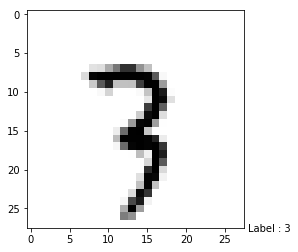

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
def visualize_digits(i):
    pixel_value_i = train_data.ix[i][1:]
    pixel_value_i = pixel_value_i.values.reshape([28,28])
    plt.imshow(pixel_value_i,cmap='Greys')
    plt.text(28.,28.,'Label : ' + str(train_data.ix[i]['label']))
    plt.show()
visualize_digits(192)

In [3]:
train_data_numpy=np.array(train_data)
X_train = train_data_numpy[:,1:]
Y_train=train_data_numpy[:,0]

In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from selu import *

In [5]:
# Parameters
learning_rate = 0.05
training_epochs = 20
batch_size = 512
display_step = 1

# Network Parameters
n_hidden_1 = 784 # 1st layer number of features
n_hidden_2 = 784 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_input],name="train_inp")
y = tf.placeholder("float", [None, n_classes],name="train_out")
dropoutRate = tf.placeholder(tf.float32,name="dropout")
is_training= tf.placeholder(tf.bool,name="is_training")

In [6]:
scaler = StandardScaler().fit(X_train)

c:\users\sethuiyer\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [7]:
logs_path = './logs/'  #tensorboard
# Create model
def multilayer_perceptron(x, weights, biases, rate, is_training):
    # Hidden layer with SELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    #netI_1 = layer_1
    layer_1 = selu(layer_1)
    layer_1 = dropout_selu(layer_1,rate, training=is_training)
    
    # Hidden layer with SELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    #netI_2 = layer_2
    layer_2 = selu(layer_2)
    layer_2 = dropout_selu(layer_2,rate, training=is_training)

    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [8]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=np.sqrt(1/n_input))),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=np.sqrt(1/n_hidden_1))),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=np.sqrt(1/n_hidden_2)))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1],stddev=0)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2],stddev=0)),
    'out': tf.Variable(tf.random_normal([n_classes],stddev=0))
}
# Construct model
pred = multilayer_perceptron(x, weights, biases, rate=dropoutRate, is_training=is_training)
correct_pred=tf.argmax(pred,1)
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

 # Test model
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
         
# Initializing the variables
init = tf.global_variables_initializer()
# Create a histogramm for weights
tf.summary.histogram("weights2", weights['h2'])
tf.summary.histogram("weights1", weights['h1'])

# Create a summary to monitor cost tensor
tf.summary.scalar("loss", cost)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", accuracy)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

In [9]:
def next_batch(batch_size):
    i = 0
    one_hot_y=np.zeros((batch_size,n_classes))
    while True:
        if i + batch_size >= len(train_data_numpy):
            batch_x = X_train[i:]
            batch_x=np.concatenate((batch_x,X_train[0:batch_size+i-len(train_data_numpy)]),axis=0)
            batch_y = Y_train[i:]
            batch_y=np.concatenate((batch_y,Y_train[0:batch_size+i-len(train_data_numpy)]),axis=0)
            one_hot_y[np.arange(batch_size),batch_y] = 1  #convert to one hot encoding
            batch_y = one_hot_y
            one_hot_y=np.zeros((batch_size,n_classes))  #resetting it for future use
            yield batch_x,batch_y
        else:
            batch_x = X_train[i:i+batch_size]
            batch_y = Y_train[i:i+batch_size]
            one_hot_y[np.arange(batch_size),batch_y] = 1  #convert to one hot encoding
            batch_y = one_hot_y
            one_hot_y=np.zeros((batch_size,n_classes))  #resetting it for future use
            yield batch_x,batch_y
        i = ( i + batch_size ) % len(X_train)
train_next_batch = next_batch(batch_size)

In [10]:
# Launch the graph
gpu_options = tf.GPUOptions(allow_growth=True)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)

    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(X_train)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = next(train_next_batch)
            batch_x = scaler.transform(batch_x)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y, dropoutRate: 0.0, is_training:True})

            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print ("Epoch:", '%04d' % (epoch+1), "cost=","{:.9f}".format(avg_cost))
            
            accTrain, costTrain, summary = sess.run([accuracy, cost, merged_summary_op], 
                                                        feed_dict={x: batch_x, y: batch_y, 
                                                                   dropoutRate: 0.1, is_training:False})
            summary_writer.add_summary(summary, epoch)
            
            print("Train-Accuracy:", accTrain,"Train-Loss:", costTrain)

            batch_x_test, batch_y_test = next(train_next_batch)
            batch_x_test = scaler.transform(batch_x_test)

            accTest, costVal = sess.run([accuracy, cost], feed_dict={x: batch_x_test, y: batch_y_test, 
                                                                   dropoutRate: 0.0, is_training:False})

            print("Validation-Accuracy:", accTest,"Val-Loss:", costVal,"\n")
            saver = tf.train.Saver()
            saver.save(sess,'./mnist_snn')

c:\users\sethuiyer\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Epoch: 0001 cost= 0.452737899
Train-Accuracy: 0.916016 Train-Loss: 0.278928
Validation-Accuracy: 0.910156 Val-Loss: 0.283022 

Epoch: 0002 cost= 0.289358502
Train-Accuracy: 0.935547 Train-Loss: 0.210925
Validation-Accuracy: 0.923828 Val-Loss: 0.278436 

Epoch: 0003 cost= 0.257992939
Train-Accuracy: 0.9375 Train-Loss: 0.238453
Validation-Accuracy: 0.925781 Val-Loss: 0.22384 

Epoch: 0004 cost= 0.237515091
Train-Accuracy: 0.943359 Train-Loss: 0.181955
Validation-Accuracy: 0.933594 Val-Loss: 0.232625 

Epoch: 0005 cost= 0.221627768
Train-Accuracy: 0.943359 Train-Loss: 0.202629
Validation-Accuracy: 0.949219 Val-Loss: 0.23485 

Epoch: 0006 cost= 0.207932187
Train-Accuracy: 0.953125 Train-Loss: 0.204773
Validation-Accuracy: 0.957031 Val-Loss: 0.161737 

Epoch: 0007 cost= 0.195618209
Train-Accuracy: 0.957031 Train-Loss: 0.144979
Validation-Accuracy: 0.962891 Val-Loss: 0.140367 

Epoch: 0008 cost= 0.184168392
Train-Accuracy: 0.96875 Train-Loss: 0.122484
Validation-Accuracy: 0.929688 Val-Loss: 

In [11]:
sess = tf.Session()
new_saver = tf.train.import_meta_graph('./mnist_snn.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./'))

INFO:tensorflow:Restoring parameters from ./mnist_snn


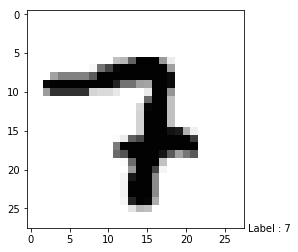

Actual Label : 7
Predicted Label :  7


In [12]:
def predict(i):
    example_x=train_data.ix[i][1:]
    example_y=train_data.ix[i][0]
    visualize_digits(i)
    example_x=example_x.values.reshape([-1,784])
    print('Actual Label :', example_y)
    preds = sess.run([correct_pred],feed_dict={x:example_x,dropoutRate: 0.0, is_training:False})
    print ('Predicted Label : ', preds[0][0])
predict(1022)